# Ripple TaylorF2 verification notebook

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta, lambdas_to_lambda_tildes
from ripple.constants import MSUN, gt
from ripple.waveforms.utils_tidal import get_quadparam_octparam
from jax import grad, vmap
from functools import partial

%load_ext autoreload
%autoreload 2
from ripple.waveforms import TaylorF2

import lalsimulation as lalsim
import lal

from ripple import get_eff_pads

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will compare waveforms with the following intrinsic parameters, which are close to the extremes on which the LAL implementation has been reviewed:

In [18]:
m1 = 3
m2 = 2

chi1 = 0.5
chi2 = 0.4

lambda1 = 1e7
lambda2 = lambda1

distance = 440.

TODO convert lambdas to lambda tildes before calling ripple waveform generator

In [19]:
# TODO implement here

Get the frequency grid:

In [20]:
# Frequency grid
T = 16
f_l = 20.0
# f_sampling = 2 * 512
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [21]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = np.pi / 2

# Convert from source values to sample values
Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
lambda_tilde, delta_lambda_tilde = lambdas_to_lambda_tildes(jnp.array([lambda1, lambda2, m1, m2]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda_tilde, delta_lambda_tilde, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = TaylorF2.gen_TaylorF2_hphc(fs_ripple, theta_ripple, f_ref)

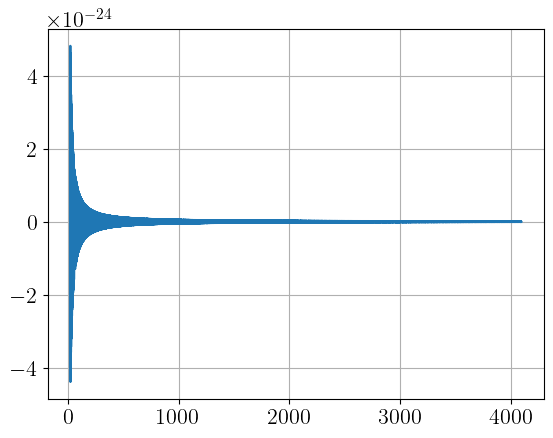

In [22]:
plt.plot(fs_ripple, hp_ripple.real)
plt.show()

## LAL

Check the LAL code (and also how to compute the mismatch between your waveform and LAL) in [this tutorial](https://github.com/tedwards2412/ripple/blob/main/test/check_waveform_match.py).

In [23]:
laldict = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)
quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
# Note that these are dquadmon, not quadmon, hence have to subtract 1 since that is added again later
lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, quad1 - 1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, quad2 - 1)

0

Checking the computation for quad parameters:

In [24]:
print(quad1, quad2)
my_quad1, _ = get_quadparam_octparam(lambda1)
my_quad2, _ = get_quadparam_octparam(lambda2)
print(my_quad1, my_quad2)

103.59051650256046 103.59051650256046
103.59051650256028 103.59051650256028


In [25]:
IMRphenom = "TaylorF2"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/psds/O3Livingston.txt", unpack=True)

theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI # in m

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

## Comparison

In [26]:
# One frequency variable, just f
f = freqs_lal[mask_lal]

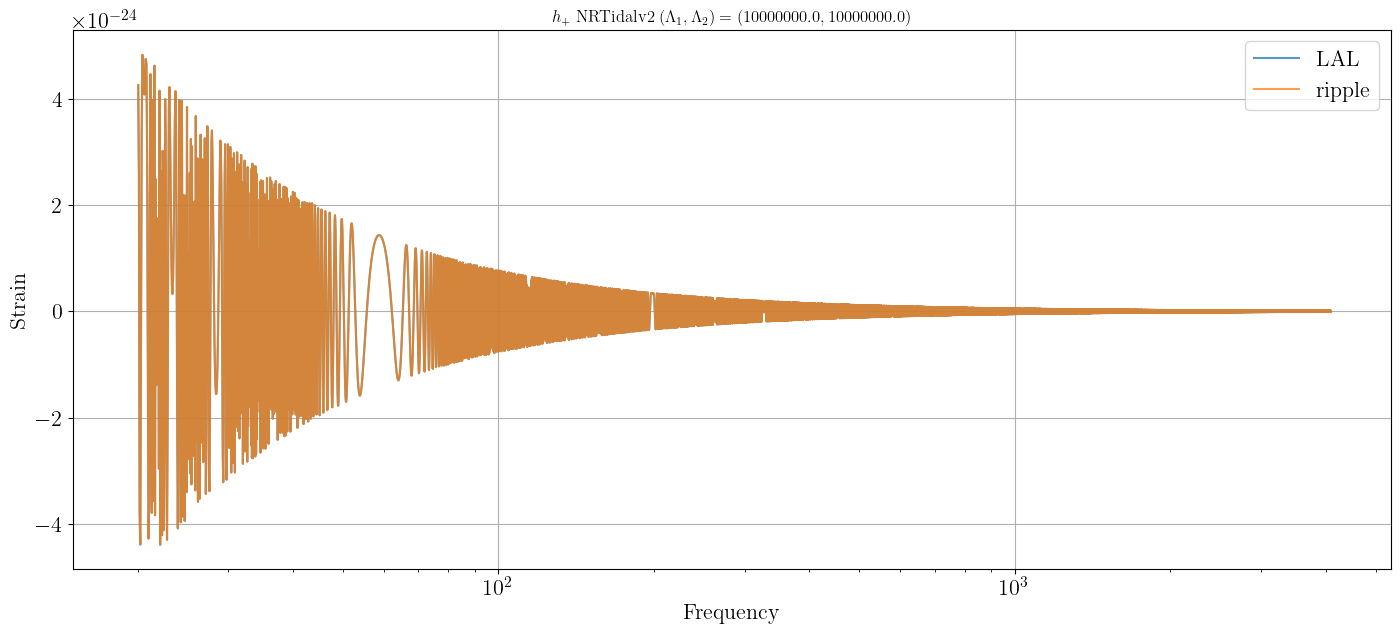

In [27]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

/Users/marlindedrent/anaconda3/envs/ripple/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


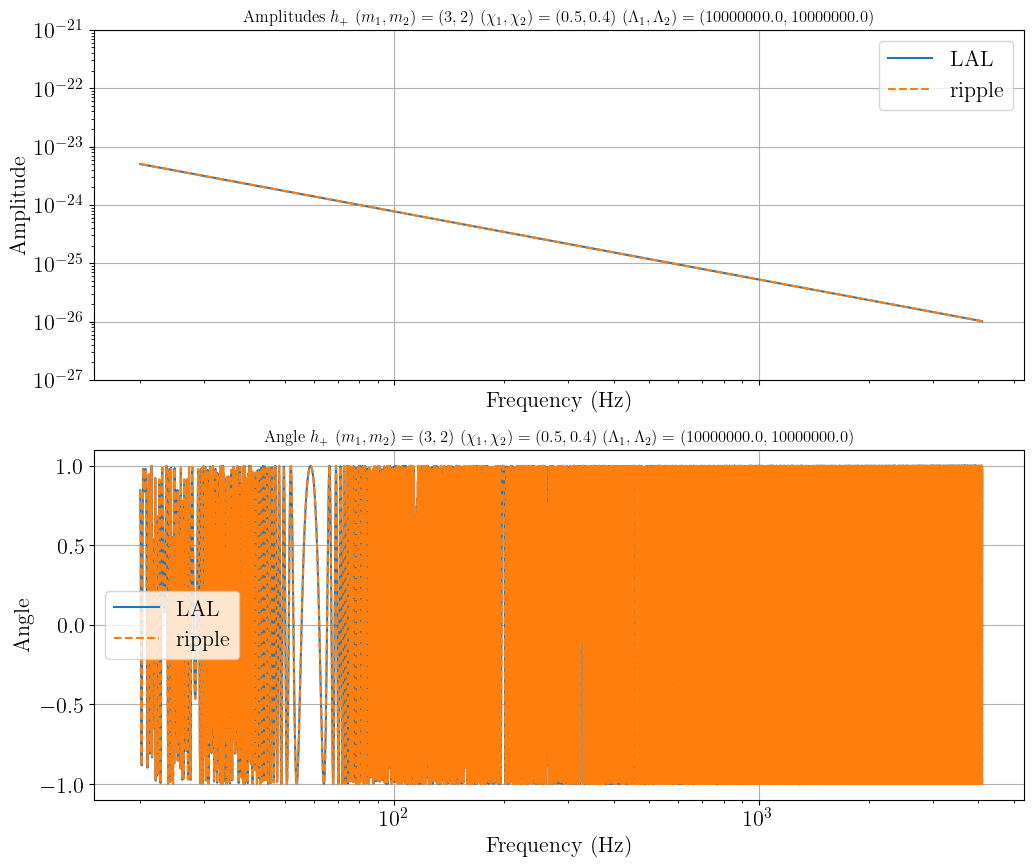

In [28]:
## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple


# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")


plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], phase_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

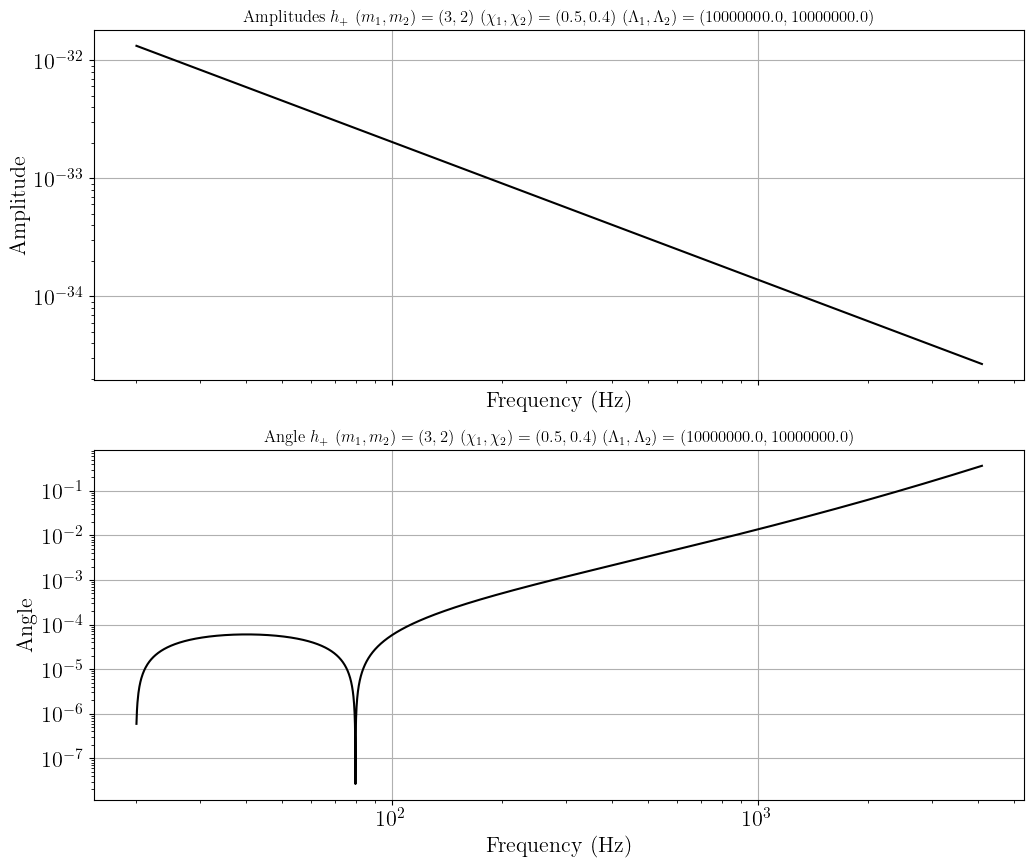

In [29]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple)
plt.plot(f, diffs_amplitude, "-", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [30]:
from ripple import get_match_arr

In [31]:
pad_low, pad_high = get_eff_pads(f)
PSD_vals = np.interp(f, f_ASD, ASD) ** 2

match = get_match_arr(
        pad_low,
        pad_high,
        # np.ones_like(fs) * 1.0e-42,
        PSD_vals,
        hp_ripple,
        hp_lalsuite,
    )

print(match)
print(np.log10(1 - match))

0.9999964190888774
-5.446006457941633
